# Feature Selection with upsampling

This post seems to be a little bit messy but mainly I tried to figure out which sampling strategy I have to use. I start with upsampling strategy and tested the data with different classification methods.  

In [1]:
# loading necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Data

In [2]:
data = pd.read_csv('thl_recoded.csv')
data.head()

,kannabis,alcohol_use,nuuska,cigarette,e_cigarette,prob_country,prob_resident,risk_of_use,risk_of_try,cannabis_access,...,household_2.0,household_3.0,education_2.0,education_3.0,education_4.0,violence_treat_2.0,violence_treat_3.0,drug_punishment_2.0,drug_punishment_3.0,drug_punishment_4.0
0,0.0,3.0,1.0,1.0,1.0,3.0,2.0,24.0,13.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,1.0,1.0,1.0,3.0,2.0,23.0,17.0,3.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,5.0,1.0,2.0,1.0,4.0,3.0,24.0,18.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,7.0,2.0,2.0,1.0,3.0,2.0,22.0,12.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,5.0,1.0,1.0,1.0,3.0,2.0,24.0,16.0,2.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [3]:
 # Kannabis use
data['kannabis'].value_counts(normalize= True)

0.0    0.914525
1.0    0.085475
Name: kannabis, dtype: float64

In [4]:
from sklearn.model_selection import train_test_split

X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [5]:
print('Dimension of X train: ', X_train.shape)
print('Target 1: ', np.count_nonzero(y_train == 1))
print('Target 0: ', np.count_nonzero(y_train == 0))



print('\n ---------------------\n')
print('Dimension of X test :', X_test.shape)
print('Target 1: ', np.count_nonzero(y_test == 1))
print('Target 0: ', np.count_nonzero(y_test == 0))




Dimension of X train:  (2260, 48)
Target 1:  193
Target 0:  2067

 ---------------------

Dimension of X test : (969, 48)
Target 1:  83
Target 0:  886


## 1.1. Scaling

Robust Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).



In [6]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()
X_train_std = robust.fit_transform(X_train)
X_test_std = robust.transform(X_test)

# 2. Model

In [8]:
# Oversampling with SMOTE 

# Because the Target is imbalance, i try to balance the data with SMOTE(OverSampling)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 101)
X_oversample, y_oversample = smote.fit_resample(X_train, y_train)


print('Dimension of X train with SMOTE: ', X_oversample.shape)
print('\n -------------- ')
print('Target 1 after SMOTE: ', np.count_nonzero(y_oversample == 1))
print('Target 0 after SMOTE: ', np.count_nonzero(y_oversample== 0))


Dimension of X train with SMOTE:  (4134, 48)

 -------------- 
Target 1 after SMOTE:  2067
Target 0 after SMOTE:  2067


## 2.1. Random Forest

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np

In [12]:
from sklearn.ensemble import RandomForestClassifier

rfecv= RFECV(estimator=RandomForestClassifier())

model = RandomForestClassifier(n_estimators=100, random_state=92116)

In [13]:
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=92116)
n_scores = cross_val_score(pipeline, X_oversample, y_oversample, scoring='f1_macro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9708729697891966

In [14]:
pipeline.fit(X_oversample, y_oversample)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=RandomForestClassifier())),
                ('Model', RandomForestClassifier(random_state=92116))])

In [15]:
print('Optimal number of features : %d' % rfecv.n_features_)

Optimal number of features : 47


In [16]:
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

Accuracy: 0.9298
Precision: 0.92
Recall: 0.9298
F1 Score: 0.9221
Cohen Kappa Score: 0.4571
Matthews Corrcoef: 0.4728
roc_auc_score: 0.6886371671788735
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.95      0.96       918
         1.0       0.40      0.65      0.49        51

    accuracy                           0.93       969
   macro avg       0.69      0.80      0.73       969
weighted avg       0.95      0.93      0.94       969

Confusion Matrix:
 [[868  18]
 [ 50  33]]


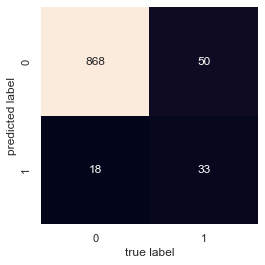

In [17]:
y_pred = pipeline.predict(X_test)
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)


plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

## 2.2. RFE GradientBoostingClassifier

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=GradientBoostingClassifier())
model = GradientBoostingClassifier()

In [19]:
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=36851234)
n_scores = cross_val_score(pipeline, X_oversample, y_oversample, scoring='f1_macro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9636662903224437

In [21]:
pipeline.fit(X_oversample, y_oversample)

Pipeline(steps=[('Feature Selection',
                 RFECV(estimator=GradientBoostingClassifier())),
                ('Model', GradientBoostingClassifier())])

In [22]:
print('Optimal number of features : %d' % rfecv.n_features_)

Optimal number of features : 10


In [23]:
rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)
rfecv.support_rfecv_df.head(15)

,Rank
nuuska,1
e_cigarette,1
prob_country,1
risk_of_try,1
violence_treat_2.0,1
household_2.0,1
"age_bins_(24, 34]",1
drug_offer_1,1
drug_user_friend_1,1
has_child_1,1


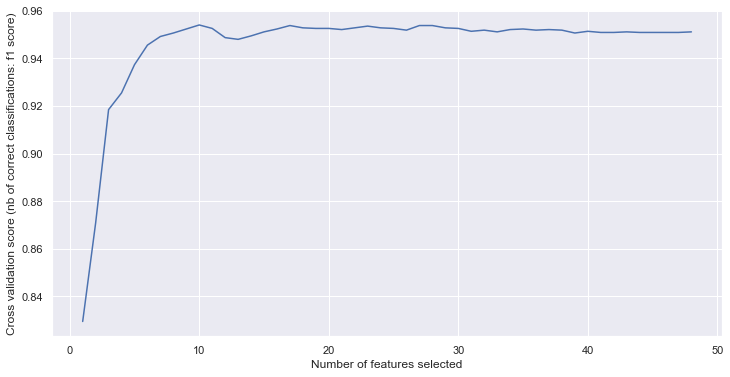

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications: f1 score)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Accuracy: 0.9257
Precision: 0.9196
Recall: 0.9257
F1 Score: 0.9221
Cohen Kappa Score: 0.4802
Matthews Corrcoef: 0.4835
roc_auc_score: 0.7191384046343388
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       902
         1.0       0.47      0.58      0.52        67

    accuracy                           0.93       969
   macro avg       0.72      0.77      0.74       969
weighted avg       0.93      0.93      0.93       969

Confusion Matrix:
 [[858  28]
 [ 44  39]]


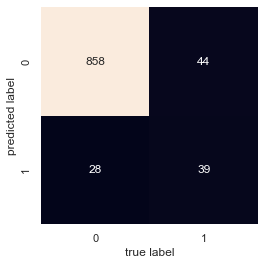

In [26]:
y_pred = pipeline.predict(X_test)
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

## 2.3. SVC

In [28]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.

rfecv = RFECV(estimator=SVC(kernel="linear"))

model = SVC(kernel="linear")

In [30]:
pipeline = Pipeline([('Feature Selection', rfecv), ('Model', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=36851234)
n_scores = cross_val_score(pipeline, X_oversample, y_oversample, scoring='f1_macro', cv=cv, n_jobs=-1)
np.mean(n_scores)

0.9103275933560365

In [31]:
pipeline.fit(X_oversample, y_oversample)

Pipeline(steps=[('Feature Selection', RFECV(estimator=SVC(kernel='linear'))),
                ('Model', SVC(kernel='linear'))])

In [32]:
print('Optimal number of features : %d' % rfecv.n_features_)

Optimal number of features : 48


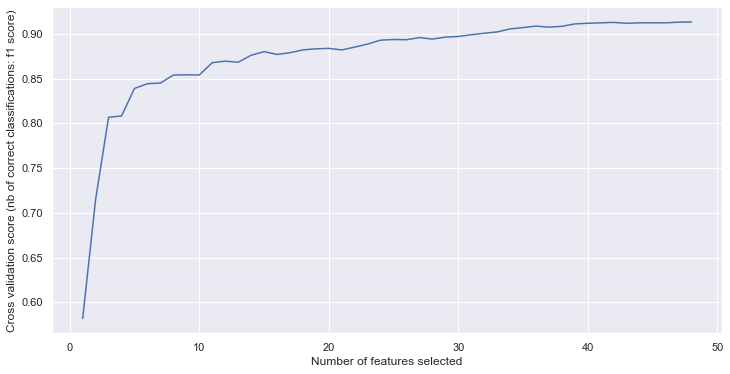

In [33]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications: f1 score)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Accuracy: 0.8596
Precision: 0.9213
Recall: 0.8596
F1 Score: 0.8813
Cohen Kappa Score: 0.4121
Matthews Corrcoef: 0.453
roc_auc_score: 0.8140553183388181
		Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.97      0.92       790
         1.0       0.76      0.35      0.48       179

    accuracy                           0.86       969
   macro avg       0.81      0.66      0.70       969
weighted avg       0.85      0.86      0.84       969

Confusion Matrix:
 [[770 116]
 [ 20  63]]


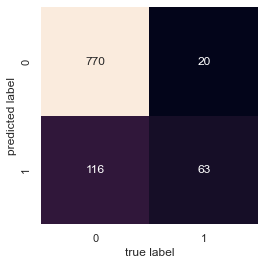

In [35]:
y_pred = pipeline.predict(X_test)
from sklearn import metrics
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred,average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test, y_pred,
                                               average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred,
                                               average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(y_test, y_pred),4)) 

from sklearn.metrics import roc_auc_score
print("roc_auc_score:", roc_auc_score(y_test, y_pred, average=None))

print('\t\tClassification Report:\n', metrics.classification_report(y_pred,y_test))


from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))


#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
from io import BytesIO #neded for plot
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

plt.savefig("Confusion.jpg")
# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

In [36]:
# list of features for further use
rfecv.support_rfecv_df = pd.DataFrame(rfecv.ranking_,index=data.columns[1:],columns=['Rank']).sort_values(by='Rank',ascending=True)

dt_columns = rfecv.support_rfecv_df [rfecv.support_rfecv_df ['Rank']==1].reset_index()
dt_columns = list(np.array(dt_columns['index']))
dt_columns 

['alcohol_use',
 'alcohol_hp_1',
 'drug_hp_1',
 'medicine_hp_1',
 'poly_hp_1',
 'doping_hp_1',
 'employment_1',
 'gender_2',
 'gender_3',
 'age_bins_(24, 34]',
 'drug_offer_1',
 'age_bins_(34, 44]',
 'age_bins_(54, 70]',
 'household_2.0',
 'household_3.0',
 'education_2.0',
 'education_3.0',
 'education_4.0',
 'violence_treat_2.0',
 'violence_treat_3.0',
 'drug_punishment_2.0',
 'age_bins_(44, 54]',
 'drug_user_friend_1',
 'rural_1',
 'small_city_1',
 'nuuska',
 'cigarette',
 'e_cigarette',
 'prob_country',
 'prob_resident',
 'risk_of_use',
 'risk_of_try',
 'cannabis_access',
 'other_drug_access',
 'intoxicant_access',
 'doping_access',
 'current_health',
 'sport',
 'has_child_1',
 'non_medical_1',
 'single_1',
 'divorced_1',
 'in_relation_1',
 'helsinki_1',
 'bigger_city_1',
 'midsize_city_1',
 'drug_punishment_3.0',
 'drug_punishment_4.0']

# 3. Summary

It seems that upsampling stragegies improve the f1 score and some other indicators but the model still beyond the satisfactory level, which enforces us to try downsampling and hybrit sampling techniques. 